In [ ]:
# pragma pylint: disable=line-too-long

In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from casacore.tables import table, taql
from pyuvdata import UVData

### Parameters
The values in the cell below are intended to be set via Papermill

In [2]:
param_measurement_set = "/home/jovyan/sdp-data/product/eb-notebook-20240612-70770/ska-sdp/pb-notebook-20240612-70771/output.scan-1.ms"
param_figures_folder = "."
param_band_channels = ""

In [ ]:
os.makedirs(param_figures_folder, exist_ok=True)

### Helper functions

In [3]:
def waterfall_plot(uv, station1=0, station2=0, pol_index=0):
    pol_name = uv.get_pols()[pol_index]
    station1_name = 1 + station1
    station2_name = 1 + station2
    waterfall_data = uv.get_data((station1, station2, uv.polarization_array[pol_index]))
    waterfall_times = Time(
        uv.get_times(station1, station2, uv.polarization_array[pol_index]),
        format="jd",
    ).iso
    title = f"Waterfall plot from Station {station1_name} to Station {station2_name} polarisation {pol_name}"
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    _ = ax.imshow(np.log10(np.abs(waterfall_data)), interpolation="none", aspect="auto")
    # _ = ax.imshow(np.abs(waterfall_data), interpolation='none', aspect='auto')
    _ = ax.set_yticks([0, waterfall_times.size - 1])
    _ = ax.set_yticklabels([waterfall_times[0], waterfall_times[-1]])
    freq_tick_inds = np.concatenate((np.arange(0, uv.Nfreqs, 500), [uv.Nfreqs - 1]))
    _ = ax.set_xticks(freq_tick_inds)
    _ = ax.set_xticklabels(
        [f"{val:.2f}" for val in uv.freq_array[freq_tick_inds] * 1e-6]
    )
    _ = ax.set_xlabel("Frequency (MHz)")
    filename = f"{title}.png"
    plt.savefig(os.path.join(param_figures_folder, filename))
    fig.show

In [4]:
def spectrum_plot(uv, index1, index2, pol_index):
    station_name1 = index1 + 1
    station_name2 = index2 + 1
    fig, ax = plt.subplots(1, 1)
    pol_name = uv.get_pols()[pol_index]
    data = uv.get_data((index1, index2, uv.polarization_array[pol_index]))
    means = np.abs(np.mean(data, axis=0))
    title = f"Average amplitude per freq from Station {station_name1} to Station {station_name2} polarisation {pol_name}"
    ax.set_title(title)
    freqs = uv.freq_array * 1e-6
    ax.plot(freqs, means, label="")
    filename = f"{title}.png"
    plt.savefig(os.path.join(param_figures_folder, filename))
    fig.show()

In [5]:
def get_uv_data(
    uv,
    station_index1,
    station_index2,
    pol_index,
    start_time=None,
    finish_time=None,
):
    u = uv
    if all([start_time is not None, finish_time is not None]):
        uv2 = uv.copy()
        uv2.select(time_range=[start_time, finish_time])
        u = uv2
    return u.get_data(
        (station_index1, station_index2, uv.polarization_array[pol_index])
    )

In [6]:
def get_peak(
    uv: UVData,
    station_index1,
    station_index2,
    pol_index,
    start_time=None,
    finish_time=None,
):
    data = get_uv_data(
        uv, station_index1, station_index2, pol_index, start_time, finish_time
    )
    avg_values = np.abs(np.mean(data, axis=0))
    peak_freq_index = np.argmax(avg_values)
    peak_amp = avg_values[peak_freq_index]
    peak_freq_value = uv.freq_array[peak_freq_index]
    peak_freq_mhz = peak_freq_value / 1e6

    if station_index1 == station_index2:
        # if auto subtract noise floor by looking at mean of values +- 10 channels either side of peak index
        left_side = peak_freq_index - 10
        left_noise_amp = avg_values[left_side]
        right_side = peak_freq_index + 10
        right_noise_amp = avg_values[right_side]
        noise_avg = (left_noise_amp + right_noise_amp) / 2.0
        peak_amp = peak_amp - noise_avg
    else:
        # for cross noise is cancelled out as is uncorrelated so we don't care
        noise_avg = None

    return peak_amp, peak_freq_mhz, noise_avg

In [7]:
def cross_auto_geom_mean_difference(
    uv: UVData, pol_index, start_time=None, finish_time=None
):
    station1_auto_amp, _, station1_auto_noise_floor = get_peak(
        uv, 0, 0, pol_index, start_time, finish_time
    )
    station2_auto_amp, _, station2_auto_noise_floor = get_peak(
        uv, 1, 1, pol_index, start_time, finish_time
    )
    cross_amp, cross_freq, _ = get_peak(uv, 0, 1, pol_index, start_time, finish_time)
    geom_mean = np.sqrt(station1_auto_amp * station2_auto_amp)
    diff = cross_amp - geom_mean
    percentage = 100.0 * (diff / geom_mean)
    results = {
        "station1_auto_amp": station1_auto_amp,
        "station1_auto_noise_floor": station1_auto_noise_floor,
        "station2_auto_amp": station2_auto_amp,
        "station2_auto_noise_floor": station2_auto_noise_floor,
        "cross_amp": cross_amp,
        "cross_freq": cross_freq,
        "geom_mean": geom_mean,
        "diff": diff,
        "percentage": percentage,
        "polarisation": uv.get_pols()[pol_index],
        "start_time": "" if start_time is None else start_time,
        "finish_time": "" if finish_time is None else finish_time,
    }

    return results

### SDP Correlation Matrix

In [8]:
try:
    columns = [f"baseline_{number}" for number in range(1, 4)]
    t = table(param_measurement_set)
    sdp_vis = t.getcol("DATA")
    sdp_vis = sdp_vis.reshape(
        (len(t) // 3, 3, 144 * band_channels, 4)  # noqa: F821 # pylint: disable=E0602
    )
    sdp_vis_df = pd.DataFrame(
        sdp_vis[:50, :, 1000, 0], columns=columns
    )  # In order to match the data
    sdp_vis_baseline_means = abs(sdp_vis_df).astype(int).mean()

    n = int(np.sqrt(len(sdp_vis[0]) * 2))
    idx = np.tril_indices(n, k=0, m=n)
    sdp_corr_matrix = np.zeros((n, n))
    sdp_corr_matrix[idx] = sdp_vis_baseline_means

    ax = plt.imshow(sdp_corr_matrix)
    ax.figure.colorbar(ax)
    plt.title("SDP Correlation Matrix")
    !mkdir -p figures
    plt.savefig(f"{param_figures_folder}/sdp_corr_matrix.png")
    plt.show()
except Exception as ex:
    print(f"Error creating Correlation Matrix PLot: {ex}")

Successful readonly open of default-locked table /home/jovyan/sdp-data/product/eb-notebook-20240612-70770/ska-sdp/pb-notebook-20240612-70771/output.scan-1.ms: 22 columns, 195 rows
Error creating Correlation Matrix PLot: name 'band_channels' is not defined


### UV Plot with colours

In [9]:
uv_data = {}
with table(param_measurement_set) as tab:
    selector = taql("select UVW, DATA from $tab where ANTENNA1 != ANTENNA2")
    uv_data["uvw"] = selector.getcol("UVW") * u.m
    uv_data["data"] = selector.getcol("DATA")

Successful readonly open of default-locked table /home/jovyan/sdp-data/product/eb-notebook-20240612-70770/ska-sdp/pb-notebook-20240612-70771/output.scan-1.ms: 22 columns, 195 rows


In [10]:
first_channel_data = [data[0] for data in uv_data["data"]]
first_channel_averages = [abs(sum(data) / len(data)) for data in first_channel_data]

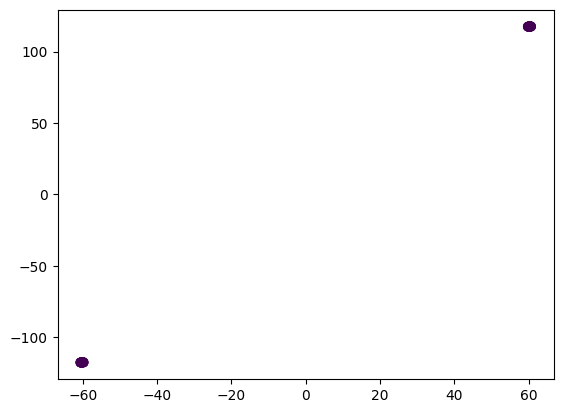

In [11]:
x, y = np.append(uv_data["uvw"][:, 0], -uv_data["uvw"][:, 0]), np.append(
    uv_data["uvw"][:, 1], -uv_data["uvw"][:, 1]
)
colours = first_channel_averages

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=colours + colours, alpha=0.5)
plt.show()

### Waterfall Plots

In [12]:
uv = UVData.from_file(param_measurement_set, use_future_array_shapes=True)

divide by zero encountered in log10


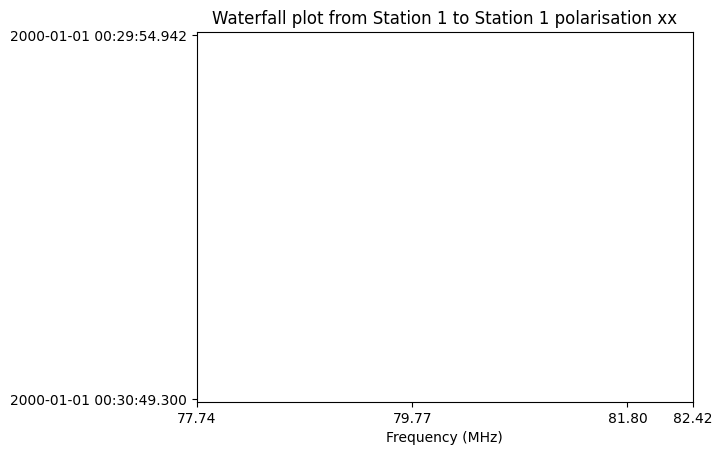

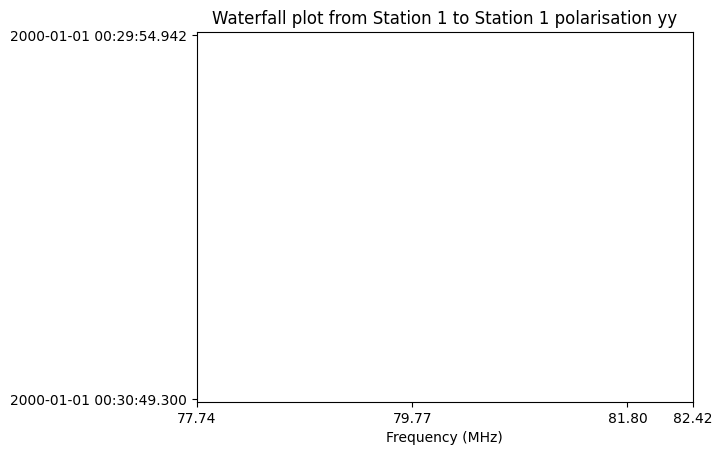

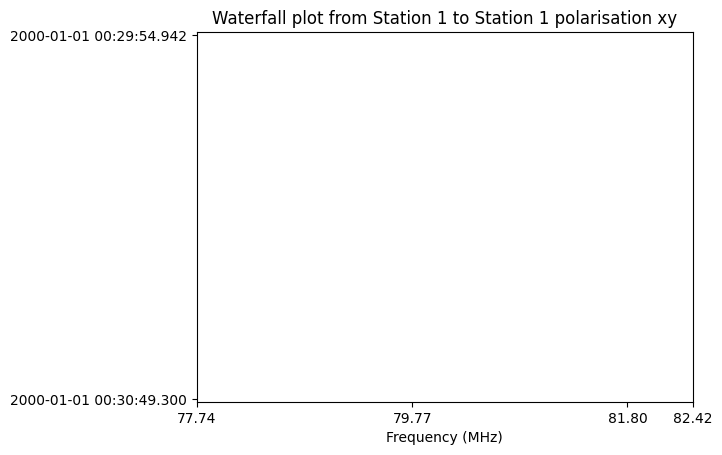

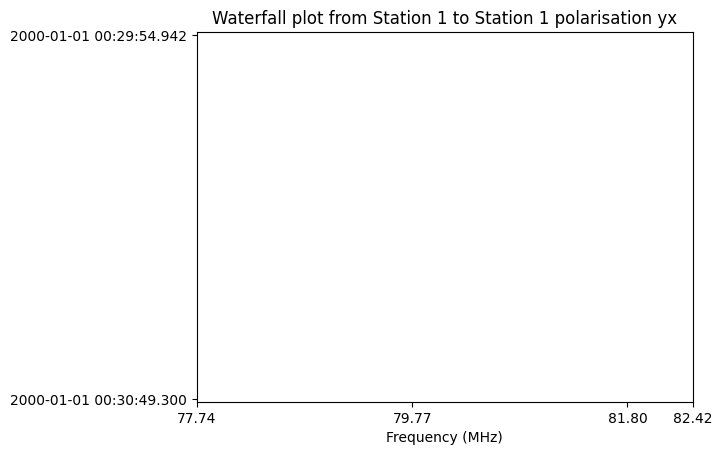

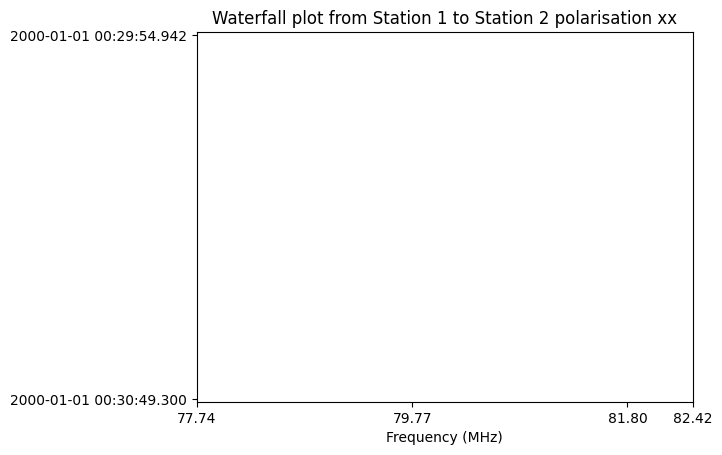

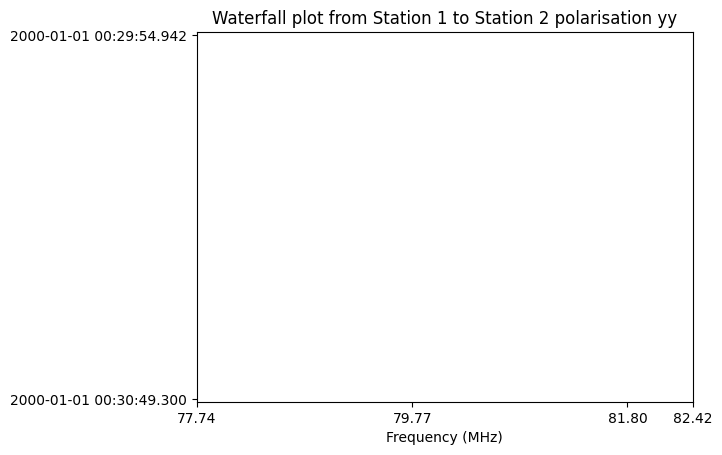

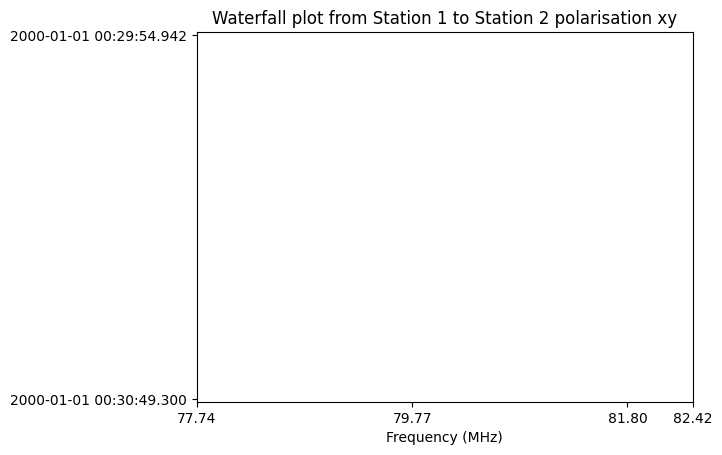

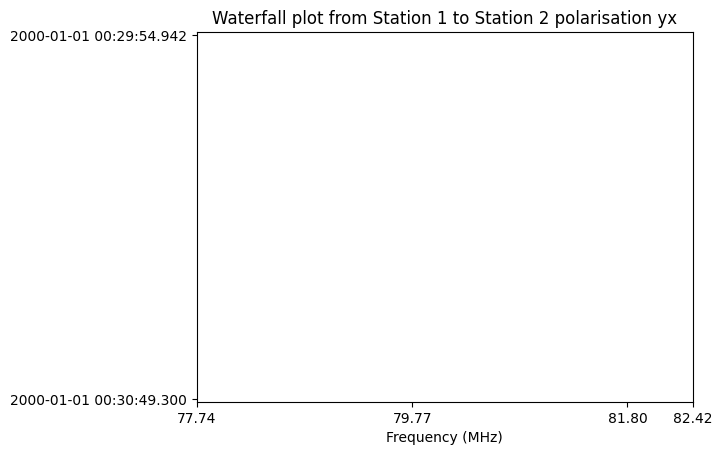

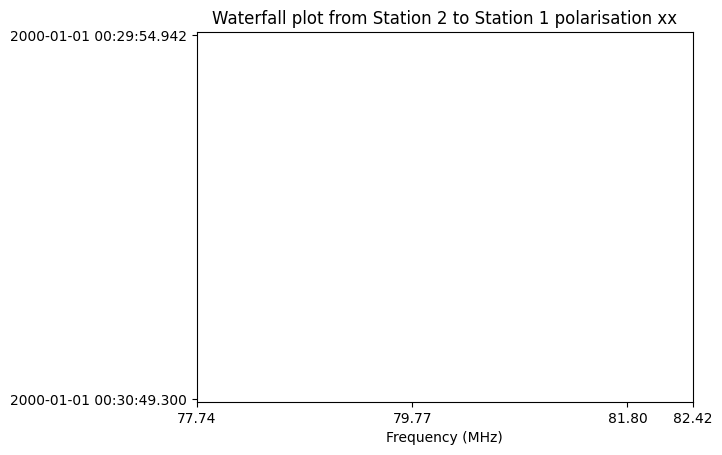

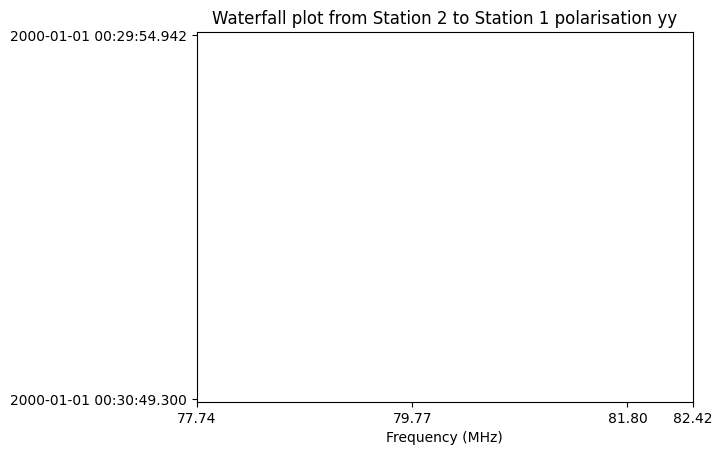

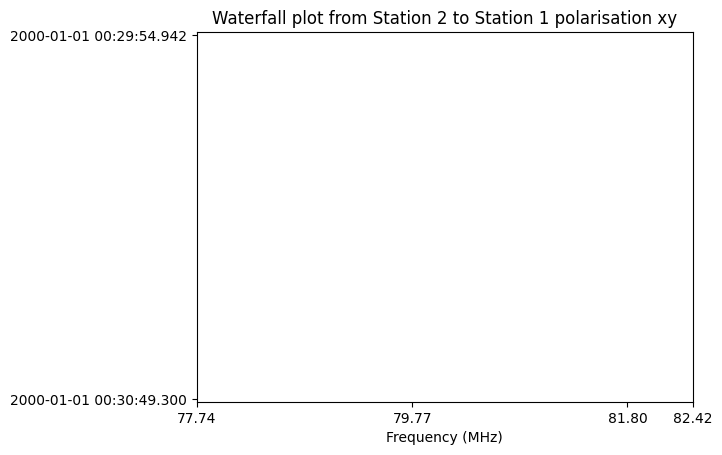

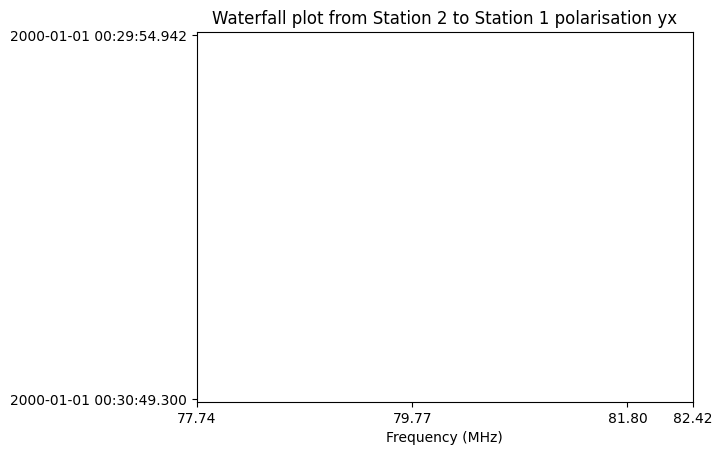

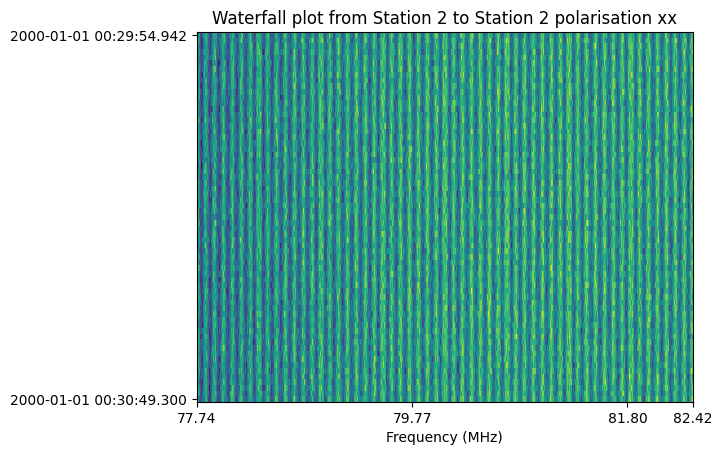

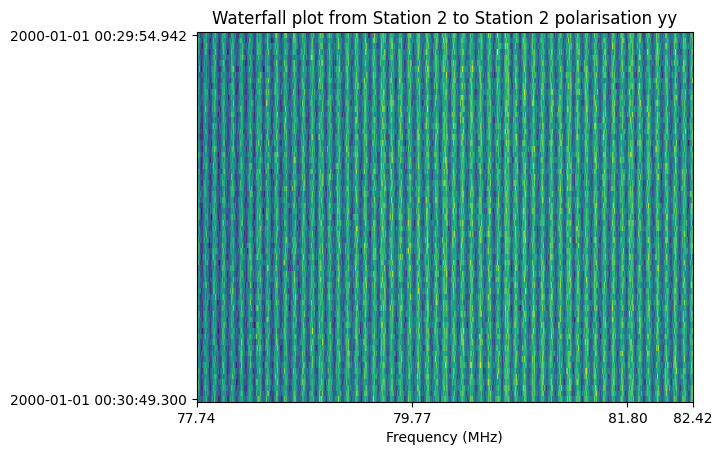

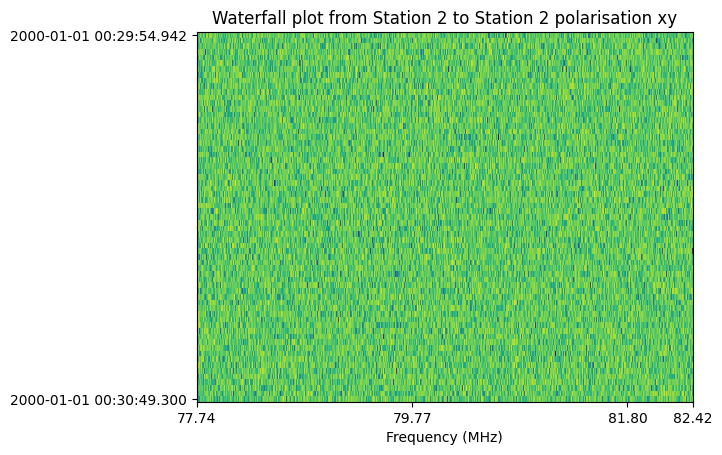

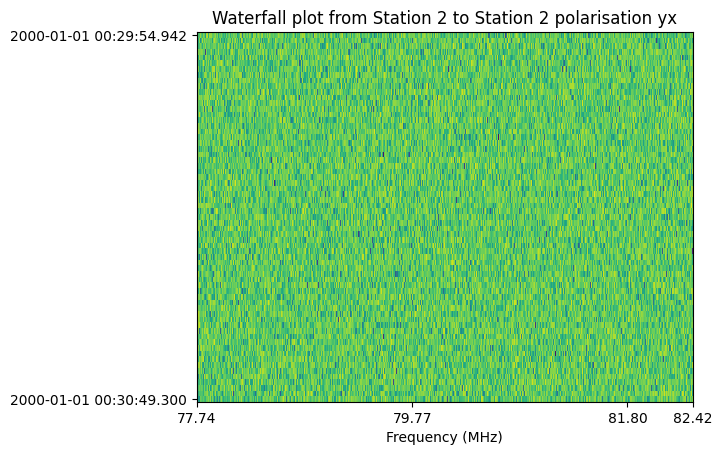

In [13]:
for s1 in [0, 1]:
    for s2 in [0, 1]:
        for pol_index in [0, 1, 2, 3]:
            waterfall_plot(uv, s1, s2, pol_index)

### Spectrum Plots showing Average Power for all Freqencies

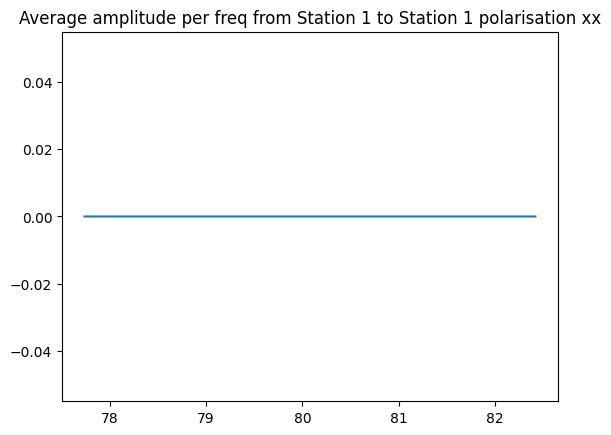

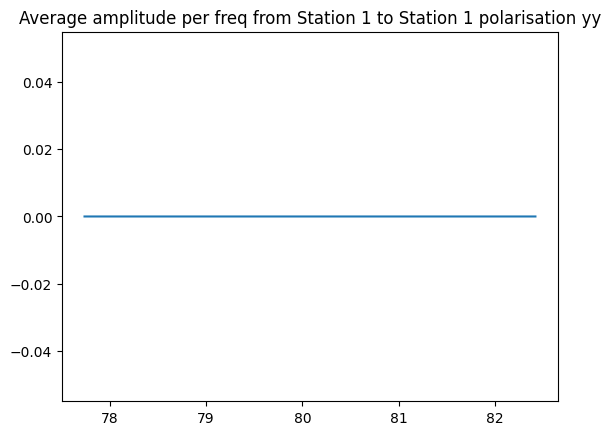

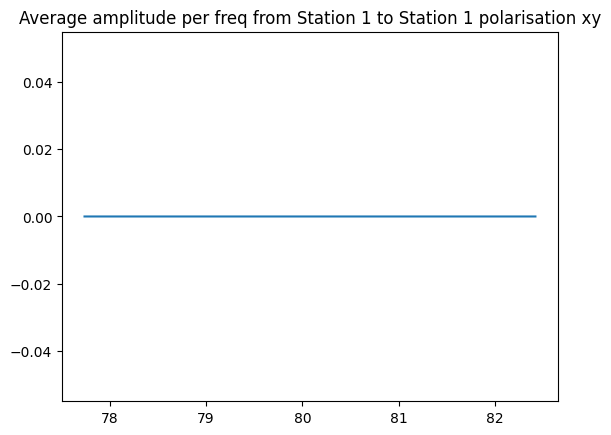

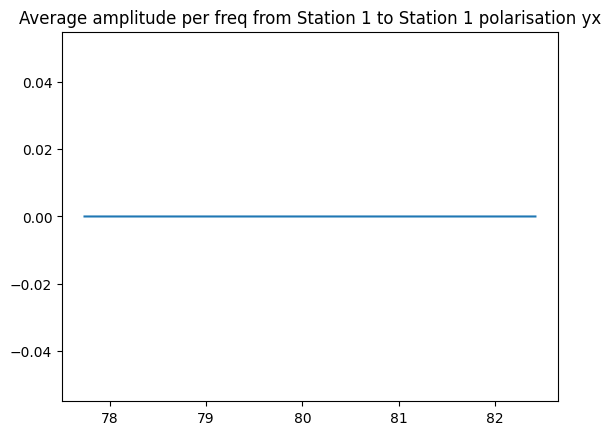

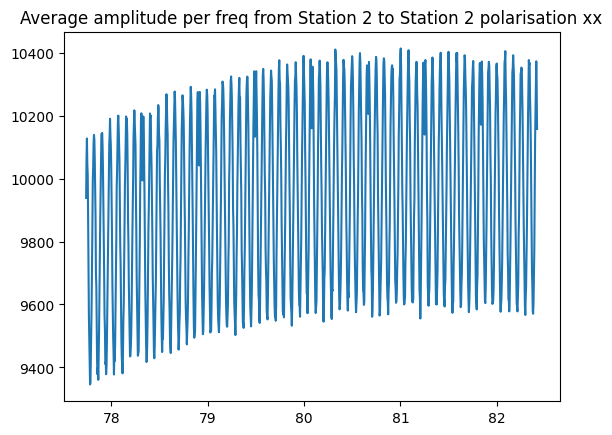

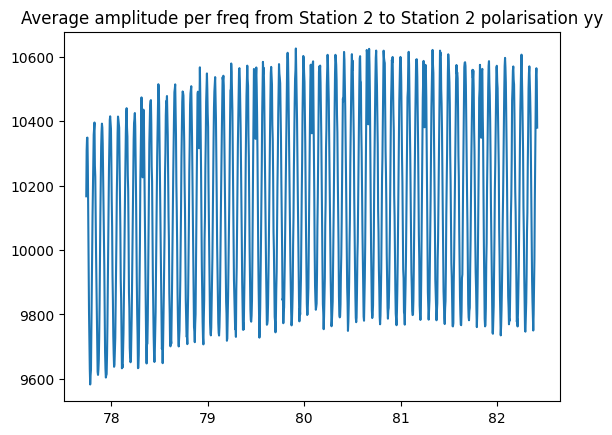

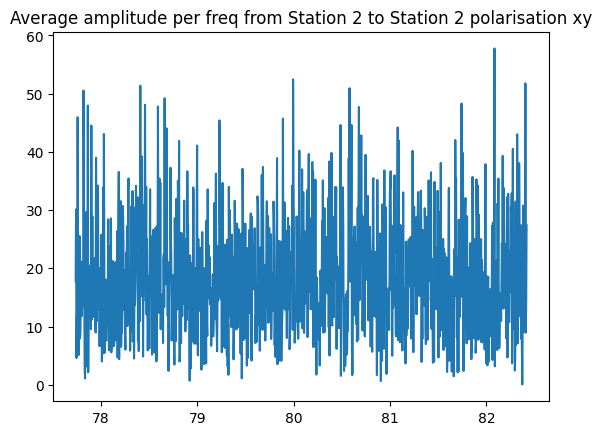

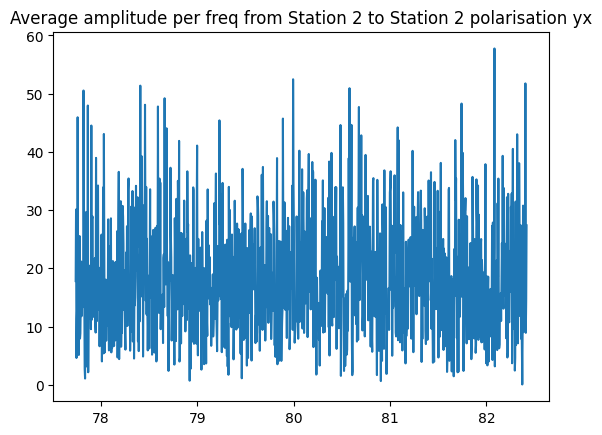

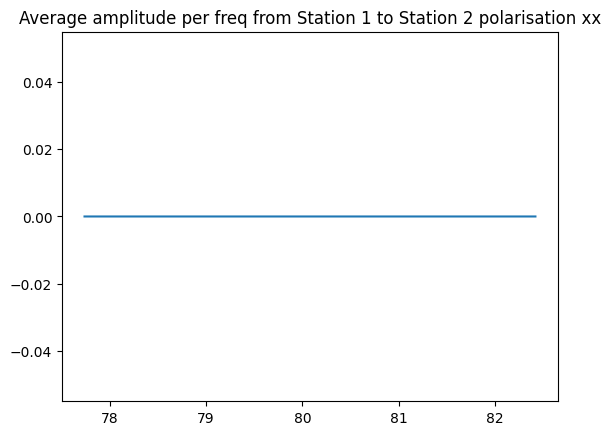

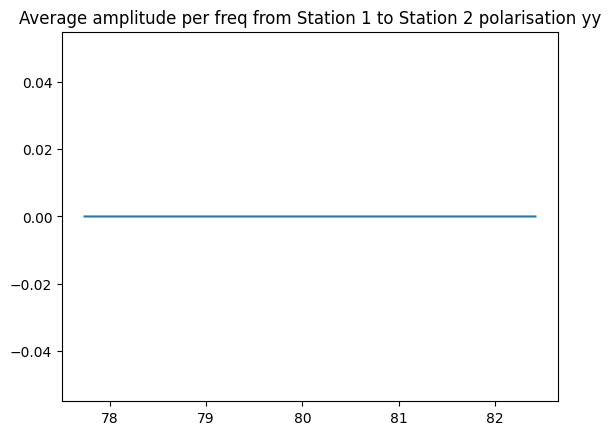

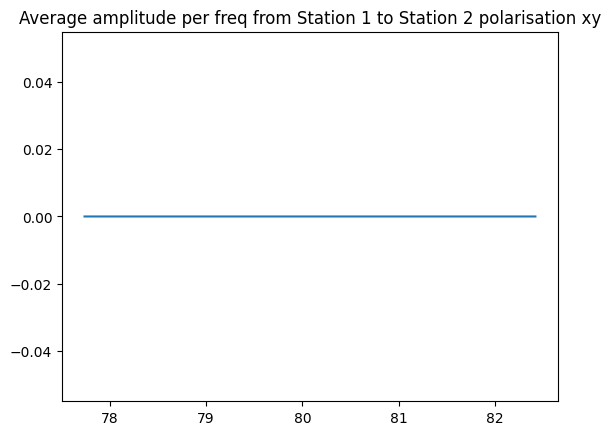

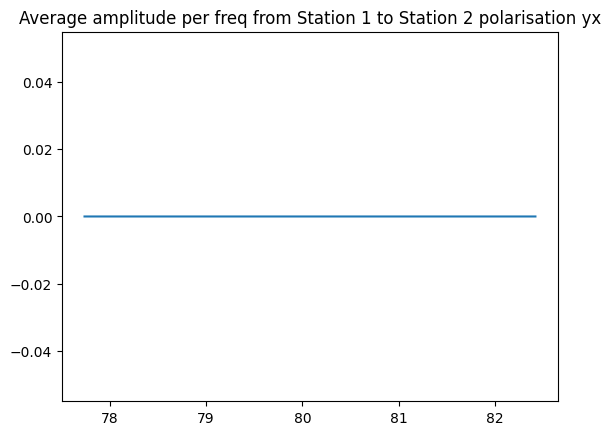

In [14]:
for baseline in [[0, 0], [1, 1], [0, 1]]:
    for pol_index in [0, 1, 2, 3]:
        spectrum_plot(uv, baseline[0], baseline[1], pol_index)

### Cross and Auto Peak Analysis

In [15]:
df = pd.DataFrame(
    {
        "station1_auto_amp": [],
        "station1_auto_noise_floor": [],
        "station2_auto_amp": [],
        "station2_auto_noise_floor": [],
        "geom_mean": [],
        "cross_amp": [],
        "diff": [],
        "percentage": [],
        "polarisation": [],
        "start_time": [],
        "finish_time": [],
    }
)

In [16]:
for i, pol_index in enumerate([0, 1, 2, 3]):
    pol_name = uv.get_pols()[pol_index]
    results = cross_auto_geom_mean_difference(uv, pol_index)
    df.loc[i] = results

filename = "cross_auto_peak_analysis.csv"
df.to_csv(os.path.join(param_figures_folder, filename))
df

invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


station1_auto_amp  station1_auto_noise_floor  station2_auto_amp  \
0                0.0                        0.0         790.714844   
1                0.0                        0.0         825.545898   
2                0.0                        0.0          31.824474   
3                0.0                        0.0          31.824474   

   station2_auto_noise_floor  geom_mean  cross_amp  diff  percentage  \
0                9623.007812        0.0        0.0   0.0         NaN   
1                9800.253906        0.0        0.0   0.0         NaN   
2                  25.936272        0.0        0.0   0.0         NaN   
3                  25.936272        0.0        0.0   0.0         NaN   

  polarisation start_time finish_time  
0           xx                         
1           yy                         
2           xy                         
3           yx